In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw
import util
from importlib import reload

reload(util)

# ------------------------------------------------------------------ constants
SIDE   = config.RES               # target size (square)
S      = config.S
ANCHOR = config.ANCHORS[0]        # (w₀, h₀) in relative units





# ------------------------------------------------------------------ main
def render_gt(gt_df, img_id,
              *, colour=(0, 255, 0, 200),
              out_dir="evaluation"):
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann.filename.iloc[0])
    pil = Image.open(img_path).convert("RGB").resize((config.RES, config.RES))

    draw = ImageDraw.Draw(pil, "RGBA")
    for _, row in ann.iterrows():
        draw.rectangle(util._gt_box_from_row(row), outline=colour, width=2)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_gt_only.png")
    pil.save(out_path)
    print(f"[render_gt] saved → {out_path}")
    return pil

In [8]:
import util
from importlib import reload
import model as m

reload(util)
reload(config)

de = util.DataExtractor()
gt_df = de.croppedData()


Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


[render_gt] saved → evaluation\1023_gt_only.png


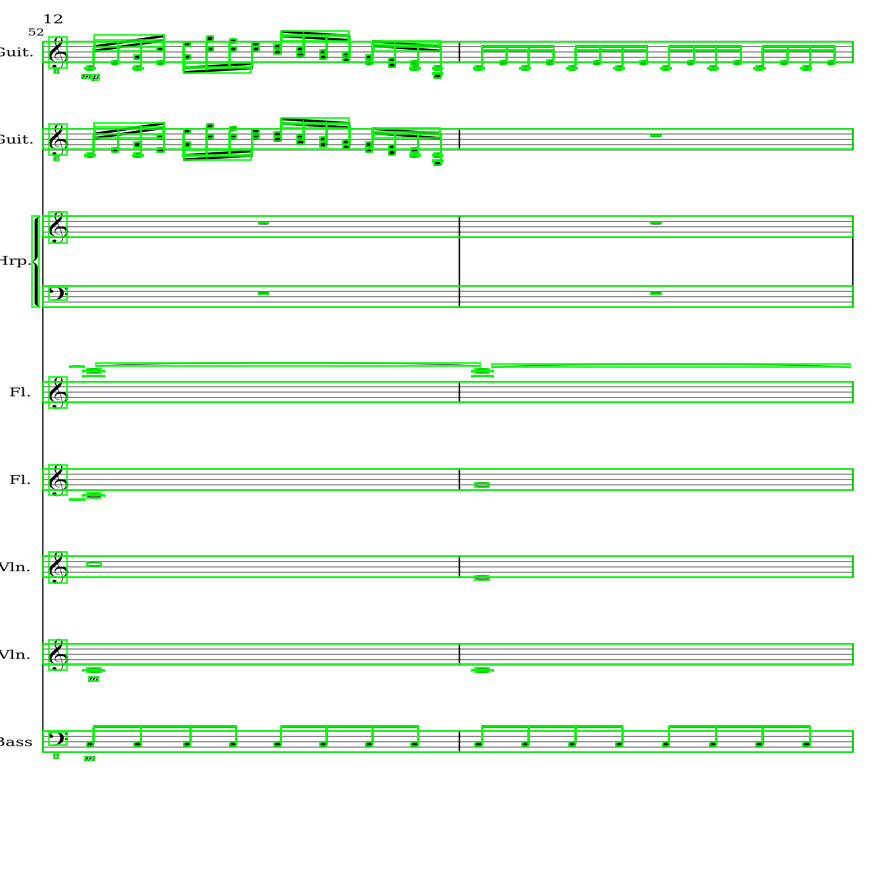

In [10]:
render_gt(gt_df, img_id=1023)

## Predictions

In [170]:
import pandas as pd
import util
from importlib import reload

reload(util)
reload(config)
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw


def render_crop_gt(
        gt_df, img_id,
        *, crop_cells, row_idx, col_idx,
        colour=(255, 0, 0, 200),
        out_dir="evaluation_crops"):
    
    """size       : output edge length (kept 896 for parity)"""

    if S % crop_cells:
        raise ValueError(f"crop_cells={crop_cells} must divide {S}")
    crops_per_dim = S // crop_cells
    if not (0 <= row_idx < crops_per_dim and 0 <= col_idx < crops_per_dim):
        raise ValueError("row_idx / col_idx outside valid range")

    page = gt_df[gt_df.img_id == img_id]
    if page.empty:
        raise ValueError(f"No rows with img_id={img_id}")

    # ---------- crop window in cell coordinates --------------------------------
    cx_min = col_idx * crop_cells
    cx_max = (col_idx + 1) * crop_cells       # exclusive
    cy_min = row_idx * crop_cells
    cy_max = (row_idx + 1) * crop_cells

    crop_boxes = page[(page.cx >= cx_min) & (page.cx < cx_max) &
                      (page.cy >= cy_min) & (page.cy < cy_max)]
    if crop_boxes.empty:
        raise ValueError("No GT boxes inside the requested crop")

    # ---------- prepare full-page canvas (896×896) ------------------------------
    img_path = os.path.join(config.img_dir, crop_boxes.filename.iloc[0])
    full = Image.open(img_path).convert("RGB").resize((config.RES, config.RES))

    # pixel window of the crop on that 896×896 full canvas
    cell_px   = config.RES / config.S                       # width/height of one grid cell
    crop_px   = crop_cells * cell_px           # edge length of the crop region
    left_px   = int(round(col_idx * crop_px))
    top_px    = int(round(row_idx * crop_px))
    right_px  = int(round(left_px + crop_px))
    lower_px  = int(round(top_px  + crop_px))

    # cut & upscale to full 896×896 preview
    crop_img  = full.crop((left_px, top_px, right_px, lower_px)).resize((config.RES, config.RES))
    scale     = config.RES / (right_px - left_px)    # same for x and y

    # ---------- draw ------------------------------------------------------------
    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in crop_boxes.iterrows():
        x0, y0, x1, y1 = util._gt_box_from_row(row)
        # shift into crop coords, then upscale
        box = [(x0 - left_px) * scale,
               (y0 - top_px)  * scale,
               (x1 - left_px) * scale,
               (y1 - top_px)  * scale]
        draw.rectangle(box, outline=colour, width=2)

    # ---------- save / return ---------------------------------------------------
    os.makedirs(out_dir, exist_ok=True)
    name = f"{img_id}_r{row_idx}_c{col_idx}_cells{crop_cells}.png"
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt] saved → {out_path}")
    return crop_img


[render_crop_gt] saved → evaluation_crops\895_r0_c8_cells10.png


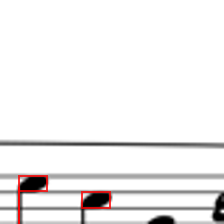

In [151]:
render_crop_gt(gt_df,
               img_id=895,
               crop_cells=10,
               row_idx=0,
               col_idx=8)

In [ ]:
import os, numpy as np, config
from PIL import Image, ImageDraw
from importlib import reload
import config
import util

reload(util)
reload(config)



# def render_crop_gt_loc(df, crop_uid,
#                        *, crop_id=None, crop_row=None, crop_col=None,
#                        colour=(0, 255, 0, 200),
#                        out_dir="evaluation_crops_loc",
#                        size=config.RES):
    
#     crop_rows = df[df.crop_uid == crop_uid]
#     if crop_rows.empty:
#         raise ValueError(f"crop_uid {crop_uid} not in dataframe")
#     crop_row = int(crop_rows.crop_row.iloc[0])
#     crop_col = int(crop_rows.crop_col.iloc[0])



#     # ---------------------------------------------------------------- load page
#     img_path = os.path.join(config.img_dir, crop_rows.filename.iloc[0])
#     crop_img, left_px, top_px, scale = util.load_crop_image(img_path, crop_row, crop_col, full_size=config.RES, crop_size=size)

#     util.drawCropBoxes(crop_rows, crop_img, top_px, left_px, scale)

#     # ---------------------------------------------------------------- save / return
#     os.makedirs(out_dir, exist_ok=True)
#     name = (f"{crop_uid}_crop{crop_id}.png" if crop_id is not None
#             else f"{crop_uid}_r{crop_row}_c{crop_col}.png")
#     out_path = os.path.join(out_dir, name)
#     crop_img.save(out_path)
#     print(f"[render_crop_gt_loc] saved → {name}")
#     return crop_img

def render_crop_gt_loc(df, crop_uid,
                       *, crop_id=None, crop_row=None, crop_col=None,
                       colour=(0, 255, 0, 200),
                       out_dir="evaluation_crops_loc",
                       size=config.RES):
    
    crop_rows = df[df.crop_uid == crop_uid]
    if crop_rows.empty:
        raise ValueError(f"crop_uid {crop_uid} not in dataframe")
    crop_row = int(crop_rows.crop_row.iloc[0])
    crop_col = int(crop_rows.crop_col.iloc[0])

    # ---------------------------------------------------------------- load page
    img_path = os.path.join(config.img_dir, crop_rows.filename.iloc[0])
    crop_img, left_px, top_px, scale, effective_full_size = util.load_crop_image(img_path, crop_row, crop_col, full_size=config.RES, crop_size=size)

    # Assuming util.drawCropBoxes is something like this; adjust if your implementation differs
    draw = ImageDraw.Draw(crop_img, "RGBA")
    for _, row in crop_rows.iterrows():
        cx_full = (row.cx + row.tx) / config.S
        cy_full = (row.cy + row.ty) / config.S
        w_full = np.exp(row.tw) * config.ANCHORS[0][0]
        h_full = np.exp(row.th) * config.ANCHORS[0][1]
        x0, y0, x1, y1 = util._rel2abs(cx_full, cy_full, w_full, h_full, side_size=effective_full_size)
        box = [(x0 - left_px) * scale,
               (y0 - top_px) * scale,
               (x1 - left_px) * scale,
               (y1 - top_px) * scale]
        draw.rectangle(box, outline=colour, width=2)

    # ---------------------------------------------------------------- save / return
    os.makedirs(out_dir, exist_ok=True)
    name = (f"{crop_uid}_crop{crop_id}.png" if crop_id is not None
            else f"{crop_uid}_r{crop_row}_c{crop_col}.png")
    out_path = os.path.join(out_dir, name)
    crop_img.save(out_path)
    print(f"[render_crop_gt_loc] saved → {name}")
    return crop_img


[render_crop_gt_loc] saved → 1004_crop8.png


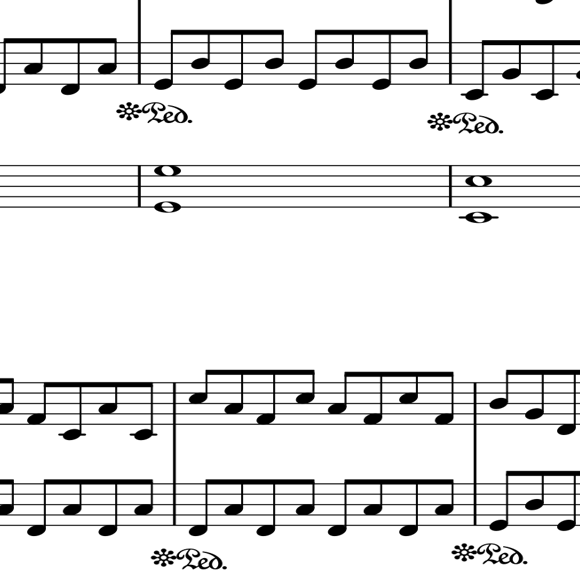

In [187]:
import util
from importlib import reload
import config
reload(util)
reload(config)

render_crop_gt_loc(gt_df, crop_uid = 1004, crop_id = 8)